In [2]:
import numpy as np
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt


In [3]:
hotel=pd.read_csv("Hotel Reservations.csv")
hotel.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [4]:
hotel.describe()
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [5]:
hotel.isnull().sum()


Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

In [6]:
hotel = hotel[~((hotel['no_of_adults'] == 0) &
                (hotel['no_of_children'] == 0))]
                
hotel['Total_Guest']=(hotel['no_of_adults']+hotel['no_of_children'])


In [7]:
hotel["total_stay_nights"] = (
    hotel["no_of_weekend_nights"] + hotel["no_of_week_nights"]
)

hotel["lead_time_category"] = pd.cut(
    hotel["lead_time"],
    bins=[-1, 30, 90, hotel["lead_time"].max()],
    labels=["short", "medium", "long"])

hotel["adr_per_person"] = hotel["avg_price_per_room"] / hotel["Total_Guest"]

hotel["weekend_booking_flag"] = (hotel["no_of_weekend_nights"] > 0).astype(int)



<Axes: xlabel='lead_time'>

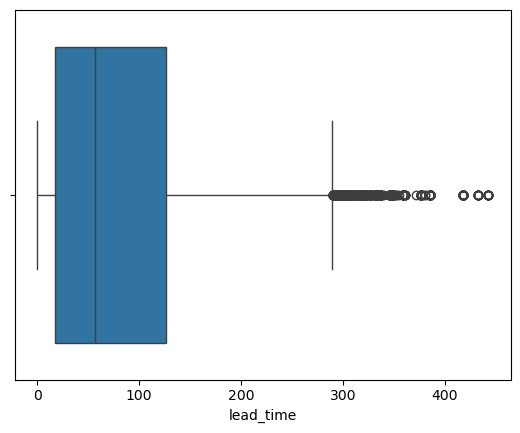

In [8]:
import seaborn as sns
sns.boxplot(x='lead_time',data=hotel)

In [9]:
def capping_outliers(series):
    q1=series.quantile(.25)
    q3=series.quantile(.75)
    iqr=q3-q1
    lower_limit=q1-1.5*iqr
    upper_limit=q3+1.5*iqr
    return series.clip(lower_limit,upper_limit)

hotel["lead_time"] = capping_outliers(hotel["lead_time"])


In [10]:
hotel["adr_per_person"] = capping_outliers(hotel["adr_per_person"])


In [11]:
hotel["total_stay_nights"] = capping_outliers(hotel["total_stay_nights"])


In [12]:
hotel=pd.get_dummies(hotel,columns=['type_of_meal_plan','room_type_reserved','market_segment_type','booking_status'],drop_first=True)

In [13]:
hotel=hotel.drop(columns=['avg_price_per_room','no_of_adults','no_of_children','no_of_weekend_nights','no_of_week_nights'])

In [14]:
hotel = hotel.replace({True: 1, False: 0})


C:\Users\Sanskar\AppData\Local\Temp\ipykernel_25412\936574034.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hotel = hotel.replace({True: 1, False: 0})


In [15]:
hotel=hotel.drop(columns='Booking_ID')

In [16]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(categories=[['short', 'medium', 'long']])
hotel['lead_time_category'] = encoder.fit_transform(hotel[['lead_time_category']])

In [25]:
x = hotel.drop(columns=['booking_status_Not_Canceled'])
y=hotel['booking_status_Not_Canceled']


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42)
from  imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)


In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=2000, solver='lbfgs')
lr.fit(X_train_scaled, y_train_resampled)

LogisticRegression(max_iter=2000)

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, roc_auc_score, confusion_matrix, classification_report
ypred_lr=lr.predict(X_test_scaled)


In [48]:
from  sklearn.ensemble import RandomForestClassifier
rfm=RandomForestClassifier(random_state=42)
rfm.fit(X_train_scaled,y_train_resampled)
ypred_rfm=rfm.predict(X_test_scaled)


In [49]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier(random_state=42)
gbc.fit(X_train_scaled,y_train_resampled)
ypred=gbc.predict(X_test_scaled)


In [50]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier(random_state=42)
param_dist = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}
rf_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    n_jobs=-1,
    cv=3,
    random_state=42,
    verbose=1
)
rf_search.fit(X_train_resampled, y_train_resampled)
print("Best RF parameters:", rf_search.best_params_)
print("Best RF CV ROC-AUC:", rf_search.best_score_)

best_rf = rf_search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RF parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best RF CV ROC-AUC: 0.9693107100774269


In [41]:
import joblib
joblib.dump(best_rf, "best_hotel_cancellation_model.pkl")

['best_hotel_cancellation_model.pkl']

In [42]:
def evaluate_model(model,y_pred,y_test):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nScores:")
    print(f"Accuracy:      {acc:.4f}")
    print(f"Precision:     {prec:.4f}")
    print(f"Recall:        {rec:.4f}")
    print(f"F1 Score:      {f1:.4f}")
    return acc, prec, rec, f1

In [46]:
lr_results = evaluate_model(lr,ypred_lr,y_test)



Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.74      0.69      2377
           1       0.86      0.79      0.83      4878

    accuracy                           0.78      7255
   macro avg       0.75      0.77      0.76      7255
weighted avg       0.79      0.78      0.78      7255

Confusion Matrix:
[[1770  607]
 [1017 3861]]

Scores:
Accuracy:      0.7762
Precision:     0.8641
Recall:        0.7915
F1 Score:      0.8262


In [51]:
rfm_results = evaluate_model(rfm,ypred_rfm,y_test)



Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      2377
           1       0.92      0.93      0.93      4878

    accuracy                           0.90      7255
   macro avg       0.89      0.89      0.89      7255
weighted avg       0.90      0.90      0.90      7255

Confusion Matrix:
[[2003  374]
 [ 330 4548]]

Scores:
Accuracy:      0.9030
Precision:     0.9240
Recall:        0.9323
F1 Score:      0.9282
